# Predicting outcomes of IVF treatments
### Using anonymized data

See the related blog post here:
https://caitlinkermen.medium.com/predicting-outcomes-of-ivf-treatments-50cc5c3a3212 

In [132]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [133]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import OneHotEncoder, OrdinalEncoder
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier

## Introduce the Dataset
Where did I source the data?
- The data for this build week was collected from https://www.hfea.gov.uk/ 

What does the data report on?
- It is the largest and longest running fertility dataset that includes outcomes for IVF (In Vitro Fertilization) and IUI (Intra Utarine Insemination). 
- I am limiting the dataset to IVF only. This is because the protocols for IVF and IUI are very different.
  - There are more factors in the outcome of IVF and the procedure costs more on average. I decided based on that the IVF portion of the dataset would lead to a more interesting model.

What are some key terms a reader would need to know in order to understand the data?
- IUI includes sperm sample collection and the use of a catheter to insert the cleaned sperm into the uterus directly.
- IVF includes egg collection and storage, sperm collection and storage, combining the egg and sperm in a lab under several protocol options, and a surgical implantation of the lab developed embryo. 

In [134]:
#Read in Data
IVF20152016 = "https://raw.githubusercontent.com/caitlinkermen/Unit_2_Build_Week/main/IVF_2015_2016.csv"
IVF2014 = "https://raw.githubusercontent.com/caitlinkermen/Unit_2_Build_Week/main/IVF_2014.csv"
df = pd.read_csv(IVF20152016)
mergedf = pd.read_csv(IVF2014)
df = pd.concat([df,mergedf])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,36,37,38,39,40,58,60,62,63) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,36,37,45,46,61) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [135]:
#Explore the Data
print(df.shape)
df.head(3)

(215761, 65)


,Patient Age at Treatment,"Total Number of Previous cycles, Both IVF and DI",Total Number of Previous IVF cycles,Total Number of Previous DI cycles,"Total number of previous pregnancies, Both IVF and DI",Total number of IVF pregnancies,Total number of DI pregnancies,Total number of live births - conceived through IVF or DI,Total number of live births - conceived through IVF,Total number of live births - conceived through DI,Type of Infertility - Female Primary,Type of Infertility - Female Secondary,Type of Infertility - Male Primary,Type of Infertility - Male Secondary,Type of Infertility -Couple Primary,Type of Infertility -Couple Secondary,Cause of Infertility - Tubal disease,Cause of Infertility - Ovulatory Disorder,Cause of Infertility - Male Factor,Cause of Infertility - Patient Unexplained,Cause of Infertility - Endometriosis,Cause of Infertility - Cervical factors,Cause of Infertility - Female Factors,Cause of Infertility - Partner Sperm Concentration,Cause of Infertility - Partner Sperm Morphology,Causes of Infertility - Partner Sperm Motility,Cause of Infertility - Partner Sperm Immunological factors,Type of treatment - IVF or DI,Specific treatment type,Egg Source,Sperm From,Fresh Cycle,Frozen Cycle,Eggs Thawed,Fresh Eggs Collected,Fresh Eggs Stored,Total Eggs Mixed,Eggs Mixed With Partner Sperm,Eggs Mixed With Donor sperm,Total Embryos Created,Eggs Micro-injected,Embryos from Eggs Micro-injected,Total Embryos Thawed,Embryos Transfered,Embryos Transfered from Eggs Micro-injected,Embryos Stored For Use By Patient,Embryos (from Eggs Micro-injected) Stored For Use By Patient,Date of Egg Collection,Date of Egg Thawing,Date of Egg Mixing,Date of Embryo Thawing,Date of Embryo Transfer,Year of Treatment,Live Birth Occurrence,Number of Live Births,Early Outcome,Heart One Weeks Gestation,Heart One Birth Outcome,Heart Two Weeks Gestation,Heart Two Birth Outcome,Heart Three Weeks Gestation,Heart Three Birth Outcome,Heart Four Weeks Gestation,Heart Four Birth Outcome,Number of foetal sacs with fetal pulsation
0,40-42,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,IVF,IVF,Patient,Partner,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,NaN,NaN,NaN,0.0,0.0,2016,1.0,1,Intrauterine Fetal Pulsation Seen,39,Live Birth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45-50,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IVF,ICSI,Patient,Partner,1,0,0,4,0,3,3,0,3,3,3,0,2,2,0,0,0.0,NaN,0.0,NaN,5.0,2016,NaN,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35-37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IVF,IVF,Patient,Partner,1,0,0,12,6,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,2016,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df.describe()

,"Total number of previous pregnancies, Both IVF and DI",Total number of IVF pregnancies,Total number of DI pregnancies,Total number of live births - conceived through IVF or DI,Total number of live births - conceived through IVF,Total number of live births - conceived through DI,Type of Infertility - Female Primary,Type of Infertility - Female Secondary,Type of Infertility - Male Primary,Type of Infertility - Male Secondary,Type of Infertility -Couple Primary,Type of Infertility -Couple Secondary,Cause of Infertility - Tubal disease,Cause of Infertility - Ovulatory Disorder,Cause of Infertility - Male Factor,Cause of Infertility - Patient Unexplained,Cause of Infertility - Endometriosis,Cause of Infertility - Cervical factors,Cause of Infertility - Female Factors,Cause of Infertility - Partner Sperm Concentration,Cause of Infertility - Partner Sperm Morphology,Causes of Infertility - Partner Sperm Motility,Cause of Infertility - Partner Sperm Immunological factors,Fresh Cycle,Frozen Cycle,Eggs Thawed,Fresh Eggs Stored,Embryos from Eggs Micro-injected,Total Embryos Thawed,Embryos Transfered,Embryos Transfered from Eggs Micro-injected,Date of Egg Collection,Date of Egg Thawing,Date of Egg Mixing,Date of Embryo Thawing,Date of Embryo Transfer,Year of Treatment,Live Birth Occurrence,Number of Live Births,Number of foetal sacs with fetal pulsation
count,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.00000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.0,215761.000000,215761.000000,215761.000000,215761.0,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,215761.000000,154551.0,1379.000000,145298.000000,54141.000000,172243.000000,215761.000000,54176.0,215761.000000,67655.000000
mean,0.192315,0.189413,0.002901,0.135553,0.133717,0.001835,0.004686,0.00177,0.004329,0.001840,0.004950,0.001237,0.113459,0.119558,0.341183,0.284950,0.059459,0.000023,0.0,0.000083,0.000065,0.000051,0.0,0.750974,0.249739,0.052359,0.133676,2.143339,0.485616,1.183082,0.542021,0.0,5.075417,2.939745,0.510334,5.714932,2015.038677,1.0,0.283480,0.341882
std,0.460268,0.456116,0.060441,0.366684,0.364024,0.045733,0.068292,0.04204,0.065652,0.042856,0.070181,0.035156,0.317154,0.324445,0.474108,0.451391,0.236483,0.004814,0.0,0.009133,0.008055,0.007140,0.0,0.432450,0.432863,0.736016,1.262499,3.720618,1.215700,0.771755,0.805815,0.0,71.020501,54.076800,21.889217,53.039031,0.815054,0.0,0.518606,0.568019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2014.000000,1.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2014.000000,1.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000,2015.000000,1.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,1.000000,0.0,0.000000,0.000000,0.000000,5.000000,2016.000000,1.0,1.000000,1.000000
max,5.000000,5.0

In [137]:
#this will help me see all the column unique values and catch things that may create issues
columns = df.columns
for col in columns:
  print(col)
  print(df[col].unique())

Patient Age at Treatment
['40-42' '45-50' '35-37' '18 - 34' '43-44' '38-39' '999']
Total Number of Previous cycles, Both IVF and DI
[2 3 0 5 1 4 '2' '0' '1' '5' '3' '4' '>=5']
Total Number of Previous IVF cycles
[2 3 0 5 4 1 '2' '0' '1' '5' '3' '4' '>=5']
Total Number of Previous DI cycles
[0 3 5 1 2 4 '0' '2' '3' '>=5' '1' '5' '4']
Total number of previous pregnancies, Both IVF and DI
[0 1 2 4 3 5]
Total number of IVF pregnancies
[0 1 2 4 3 5]
Total number of DI pregnancies
[0 1 3 2 4]
Total number of live births - conceived through IVF or DI
[0 1 2 3 5 4]
Total number of live births - conceived through IVF
[0 1 2 3 5 4]
Total number of live births - conceived through DI
[0 1 2 3]
Type of Infertility - Female Primary
[0 1]
Type of Infertility - Female Secondary
[0 1]
Type of Infertility - Male Primary
[0 1]
Type of Infertility - Male Secondary
[0 1]
Type of Infertility -Couple Primary
[0 1]
Type of Infertility -Couple Secondary
[0 1]
Cause  of Infertility - Tubal disease
[0 1]
Cause o

## Preprocess the Data
What needs to be done to preprocess the data?

- I will need to exclude outcome related columns from the model? Because I want to use the treatment to predict the outcome so if anything about the outcome is in the dataset when it is modeled it will likely affect the model. 
- I see several rows have 999 values instead of a realistic value, this needs to be corrected.
  - Columns with 999 values: Patient Age at Treatment, Date of Egg Thawing, Date of Egg Mixing, Date of Embryo Thawing, Date of Embryo Transfer
- Some numbers are showing up as strings, this needs to be corrected.
  - Columns affected: 'Fresh Eggs Collected','Total Eggs Mixed','Eggs Mixed With Partner Sperm',
'Total Embryos Created','Eggs Micro-injected'
- I need to change all strings to lowercase only and fix spelling as needed
- I want to standardize number ranges to #-# with no spaces
- in the "Early Outcome" column change None to nan
Also fix spelling 


In [138]:
#Preprocess the data

#There are only nan values in 'Date of Egg Collection' so it should be dropped
#Any column that describes the outcome after treatment need to be dropped from the dataframe
#Leave the Target in the dataframe (I have not chosen a target yet so I am keeping Live Birth Occurrence, Number of Live Births, and Early Outcome)
dropcols = ['Date of Egg Collection','Heart One Weeks Gestation','Heart Two Weeks Gestation',
              'Heart Three Weeks Gestation','Heart Four Weeks Gestation','Heart One Birth Outcome',
              'Heart Two Birth Outcome','Heart Three Birth Outcome','Heart Four Birth Outcome',
              'Number of foetal sacs with fetal pulsation']
df = df.drop(columns= dropcols)

#Clean the data 
df = df[(df["Patient Age at Treatment"] != 999) & (df["Patient Age at Treatment"] != '999')]
cleanages = {"Patient Age at Treatment": {'18 - 34':1,'35-37':2,'38-39':3,'40-42':4,'43-44':5,'45-50':6}}
df = df.replace(cleanages)  
df["Early Outcome"] = df["Early Outcome"].replace(np.nan,'None ').replace('None ','ZERO').replace(999,0)
df['Early Outcome'] = df['Early Outcome'].str.strip('None ,').replace('Misscarriag','Misscarriage')

#999 is a known value for unknown data for this dataset. Replacing the occurances with 0 for the following columns
replace999 = ['Date of Egg Thawing','Date of Egg Mixing','Date of Embryo Thawing','Date of Embryo Transfer']
for col in replace999:
  df[col] = df[col].replace("999",0).replace(999,0)

#replace NAN with 0 so column reads as int
nantozero = [replace999,'Live Birth Occurrence']
for col in nantozero:
  df[col] = df[col].replace(np.nan,0).astype(int)

#replace occurances of '> 50' with 50
fixgrint = ['Fresh Eggs Collected','Eggs Mixed With Partner Sperm','Total Eggs Mixed','Eggs Mixed With Donor sperm','Total Embryos Created','Eggs Micro-injected','Embryos Stored For Use By Patient','Embryos (from Eggs Micro-injected) Stored For Use By Patient']
for col in fixgrint:
  df[col] = df[col].replace('> 50',50).astype(int)

#replace occurances of '>=5'
fixgreqint = ['Total Number of Previous DI cycles','Total Number of Previous cycles, Both IVF and DI','Total Number of Previous IVF cycles']
for col in fixgreqint:
  df[col] = df[col].replace('>=5',5).astype(int)

#encode categorical variables
encode = ["Type of treatment - IVF or DI","Specific treatment type","Egg Source","Sperm From","Early Outcome"]
for col in encode:
  df[col] = df[col].astype('category').cat.codes

### **Choose a target** 

In [139]:
#This will show me what the distribution of each category is.
print(df['Live Birth Occurrence'].value_counts(normalize= True))

0    0.744878
1    0.255122
Name: Live Birth Occurrence, dtype: float64


**What is my target metric?**
- I chose Live Birth Occurrence as the target metric
 
**How did I choose that target metric?**
- This column holds a binary classification for if the treatment worked (1) or did not work (0)
 
**Will this be a linear regression task or a classification regression task?**
- This will be a classification regression task because the target is binary.    
 
**What is my evaluation metric?**
- My evaluation metric will be precision.
 
**How did I choose that evaluation metric?**
- I chose my evaluation metric because I am predicting a binary categorical variable. Live birth outcome only evaluates to 1 if the treatment was successful and a live birth was achieved through IVF treatment. The treatment cannot be nearly successful. It either is or is not.
 
**What in my dataset could cause leakage?**
- Any column that describes the outcome of the treatment could have an affect on the results of the model. I want the elements of the treatment process to be the only inputs of the model.
 
**How will I avoid leakage in my modeling process?**
- I will drop any columns that relate to the outcome of the treatment except for the target. 



In [140]:
#split into train val test
train = df[(df['Year of Treatment']==2016)]
val =  df[(df['Year of Treatment']==2015)]
test = df[(df['Year of Treatment']==2014)]

#separate the columns that deal with information about treatment and outcomes. 
outcomes = ['Live Birth Occurrence','Number of Live Births','Early Outcome']
df_features = df.drop(columns=outcomes)
treatment = df_features.columns

#set target 
target = 'Live Birth Occurrence'
# Arrange data into X features matrix and y target vector
X_train = train[treatment]
y_train = train[target]
X_val = val[treatment]
y_val = val[target]
#only use the testing set once!
X_test = test[treatment]
y_test = test[target]

In [141]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((74791, 52), (70927, 52), (66635, 52), (74791,), (70927,), (66635,))








## Baseline

In [142]:
#Baseline
baseline = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.7517348344052092


## First Model

In [143]:
#First Model
#Linear model for classification
model1_1 = make_pipeline(
    SimpleImputer(),
    LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
)

model1_1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [144]:
#Evaluate the first model
first_model_train_score = model1_1.score(X_train, y_train)
first_model_baseline_training_set = first_model_train_score - baseline
print('First Model Training Accuracy:', first_model_train_score)
print('Did the first model do better than the baseline on the training dataset?')
if (first_model_baseline_training_set)>0:
  print('Yes it did, by', first_model_baseline_training_set)
else:
  print('No, it did worse by', first_model_baseline_training_set)

print(' ')
first_model_val_score = model1_1.score(X_val, y_val)
first_model_baseline_validation_set = first_model_val_score - baseline
print('First Model Validation Accuracy:', first_model_val_score)
print('Did the first model do better than the baseline on the validation dataset?')
if (first_model_baseline_validation_set)>0:
  print('Yes it did, by', first_model_baseline_validation_set)
else:
  print('No, it did worse by', first_model_baseline_validation_set)

First Model Training Accuracy: 0.7478974742950355
Did the first model do better than the baseline on the training dataset?
No, it did worse by -0.00383736011017366
 
First Model Validation Accuracy: 0.7391402427848351
Did the first model do better than the baseline on the validation dataset?
No, it did worse by -0.012594591620374018


In [145]:
#Tune the first model
model1_2 = make_pipeline(
    SimpleImputer(),
    LogisticRegression(solver='sag', multi_class='auto', n_jobs=-1)
)

model1_2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='sag', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [146]:
#Evaluate the first tuned model
first_model_tuned_train_score = model1_2.score(X_train, y_train)
print('First Model Tuned Training Accuracy:', first_model_tuned_train_score)
print('Did the model improve on the Training Accuracy?')
if (first_model_tuned_train_score - first_model_train_score)>0: 
  print('Yes it did, by', first_model_tuned_train_score - first_model_train_score) 
else: print('No, it did worse by', first_model_tuned_train_score - first_model_train_score)

print(" ")
first_tuned_model_baseline_training_set = first_model_tuned_train_score - baseline
print('Did the tuned first model do better than the baseline on the training dataset?')
if (first_tuned_model_baseline_training_set)>0:
  print('Yes it did, by',first_tuned_model_baseline_training_set)
else:
  print('No, it did worse by',first_tuned_model_baseline_training_set)

print(" ")
first_model_tuned_val_score = model1_2.score(X_val, y_val)
print('First Model Tuned Validation Accuracy:', first_model_tuned_val_score)
print('Did the model improve on the Validation Accuracy?')
if (first_model_tuned_val_score - first_model_val_score)>0: 
  print('Yes it did, by', first_model_tuned_val_score - first_model_val_score) 
else: print('No, it did worse by', first_model_tuned_val_score - first_model_val_score)

print(" ")
first_tuned_model_baseline_validation_set = first_model_tuned_val_score - baseline
print('Did the tuned first model do better than the baseline on the validation dataset?')
if (first_tuned_model_baseline_validation_set)>0:
  print('Yes it did, by',first_tuned_model_baseline_validation_set)
else:
  print('No, it did worse by',first_tuned_model_baseline_validation_set)

First Model Tuned Training Accuracy: 0.748378815632897
Did the model improve on the Training Accuracy?
Yes it did, by 0.00048134133786148503
 
Did the tuned first model do better than the baseline on the training dataset?
No, it did worse by -0.003356018772312175
 
First Model Tuned Validation Accuracy: 0.7404796480888801
Did the model improve on the Validation Accuracy?
Yes it did, by 0.0013394053040449716
 
Did the tuned first model do better than the baseline on the validation dataset?
No, it did worse by -0.011255186316329047


In [147]:
#Evaluate the model to see if the first iteration was better than the second or vise-versa
evaluate1 = {
    'Model Name': ['Model 1'],
    'Train 1': [first_model_train_score],
    'Train 2': [first_model_tuned_train_score],
    'Val 1': [first_model_val_score],
    'Val 2': [first_model_tuned_val_score]
}

evaluate1 = pd.DataFrame.from_dict(evaluate1)

evaluate1['Train Score'] = evaluate1['Train 2'] - evaluate1['Train 1']
evaluate1['Val Score'] = evaluate1['Val 2'] - evaluate1['Val 1']

print('Of the first model and the first tuned model, which improved the most on the baseline?')
if ((evaluate1['Train Score']>0).any() | (evaluate1['Val Score']>0).any()):
  evaluate1['Best Model'] = 'model1_2'
  print('The first model is better AFTER being tuned')
  first_model = model1_2
#elif ((evaluate1['Val Score']>0).any() | (evaluate1['Train Score']<0).any()):
#  evaluate1['Best Model'] = 'model1_2'
#  print('The first model is better AFTER being tuned')
#  first_model = model1_2
else: 
  evaluate1['Best Model'] = 'model1_1'
  first_model = model1_1
  print('The first model is better BEFORE being tuned')

evaluate1.head()

Of the first model and the first tuned model, which improved the most on the baseline?
The first model is better AFTER being tuned


,Model Name,Train 1,Train 2,Val 1,Val 2,Train Score,Val Score,Best Model
0,Model 1,0.747897,0.748379,0.73914,0.74048,0.000481,0.001339,model1_2


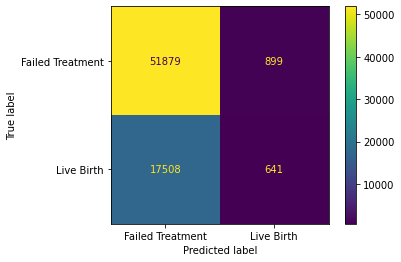

In [148]:
#Plot the Confusion Matrix for the first model
plot_confusion_matrix(first_model,
                      X_val, # <-- use validation data
                      y_val,
                      values_format='.0f',
                      display_labels=['Failed Treatment','Live Birth']);

In [149]:
TruePositive1 = 639 #Predicted live birth, actual live birth
TrueNegative1 = 51888 #Predicted failed treatment, actual failed treatment
FalsePositive1 = 890 #Predicted live birth, but was a failed treatment
FalseNegative1 = 17510 #Predicted failed treatment, but resulted in a live birth

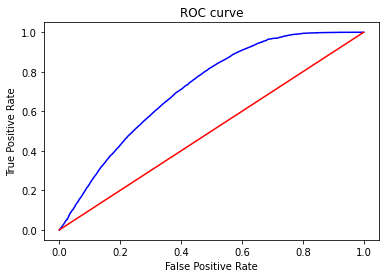

In [150]:
#Plot the ROC curve or Precision Recall Curve for the first model
y_pred_proba = first_model.predict_proba(X_val)[:,-1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

## Second Model

In [151]:
#Second Model
#Tree-based model (Decision Tree)
model2_1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='most_frequent'), 
    DecisionTreeClassifier(random_state=42)
)

model2_1.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [152]:
#Evaluate the second model
second_model_train_score = model2_1.score(X_train, y_train)
second_model_baseline_training_set = second_model_train_score - baseline
print('Second Model Training Accuracy:', second_model_train_score)
print('Did the second model do better than the baseline on the training dataset?')
if (second_model_baseline_training_set)>0:
  print('Yes it did, by', second_model_baseline_training_set)
else:
  print('No, it did worse by', second_model_baseline_training_set)
print(' ')
second_model_val_score = model2_1.score(X_val, y_val)
second_model_baseline_validation_set = second_model_val_score - baseline
print('Second Model Validation Accuracy:', second_model_val_score)
print('Did the second model do better than the baseline on the validation dataset?')
if (second_model_baseline_validation_set)>0:
  print('Yes it did, by', second_model_baseline_validation_set)
else:
  print('No, it did worse by', second_model_baseline_validation_set)

Second Model Training Accuracy: 0.9191346552392667
Did the second model do better than the baseline on the training dataset?
Yes it did, by 0.16739982083405758
 
Second Model Validation Accuracy: 0.6880595541895188
Did the second model do better than the baseline on the validation dataset?
No, it did worse by -0.06367528021569036


In [153]:
#Tune the second model
model2_2 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='constant'), 
    DecisionTreeClassifier(random_state=42,max_depth=10)
)

model2_2.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [154]:
#Evaluate the tuned second model
second_model_tuned_train_score = model2_2.score(X_train, y_train)
print('Second Model Tuned Training Accuracy:', second_model_tuned_train_score)
print('Did the model improve on the Training Accuracy?')
if (second_model_tuned_train_score - second_model_train_score)>0: 
  print('Yes it did, by', second_model_tuned_train_score - second_model_train_score) 
else: print('No it did worse by', second_model_tuned_train_score - second_model_train_score)

print(" ")
print('Did the tuned second model do better than the baseline on the training dataset?')
second_tuned_model_baseline_training_set = second_model_tuned_train_score - baseline
if (second_tuned_model_baseline_training_set)>0:
  print('Yes it did, by',second_tuned_model_baseline_training_set)
else:
  print('No it did worse by',second_tuned_model_baseline_training_set)

print(" ")
second_model_tuned_val_score = model2_2.score(X_val, y_val)
print('Second Model Tuned Validation Accuracy:', first_model_tuned_val_score)
print('Did the model improve on the Validation Accuracy?')
if (second_model_tuned_val_score - second_model_val_score)>0: 
  print('Yes it did, by', second_model_tuned_val_score - second_model_val_score) 
else: print('No it did worse by', second_model_tuned_val_score - second_model_val_score)

print(" ")
second_tuned_model_baseline_validation_set = second_model_tuned_val_score - baseline
print('Did the tuned second model do better than the baseline on the validation dataset?')
if (second_tuned_model_baseline_validation_set)>0:
  print('Yes it did, by',second_tuned_model_baseline_validation_set)
else:
  print('No it did worse by',second_tuned_model_baseline_validation_set)

Second Model Tuned Training Accuracy: 0.760853578639141
Did the model improve on the Training Accuracy?
No it did worse by -0.1582810766001257
 
Did the tuned second model do better than the baseline on the training dataset?
Yes it did, by 0.009118744233931886
 
Second Model Tuned Validation Accuracy: 0.7404796480888801
Did the model improve on the Validation Accuracy?
Yes it did, by 0.053350628110592546
 
Did the tuned second model do better than the baseline on the validation dataset?
No it did worse by -0.010324652105097809


In [155]:
#Evaluate the model to see if the first iteration was better than the second or vise-versa
evaluate2 = {
    'Model Name': ['Model 2'],
    'Train 1': [second_model_train_score],
    'Train 2': [second_model_tuned_train_score],
    'Val 1': [second_model_val_score],
    'Val 2': [second_model_tuned_val_score]
}

evaluate2 = pd.DataFrame.from_dict(evaluate2)

evaluate2['Train Score'] = evaluate2['Train 2'] - evaluate2['Train 1']
evaluate2['Val Score'] = evaluate2['Val 2'] - evaluate2['Val 1']

print('Of the second model and the second tuned model, which improved the most on the baseline?')
if ((evaluate2['Train Score']>0).any() | (evaluate2['Val Score']>0).any()):
  evaluate2['Best Model'] = 'model2_2'
  print('The second model is better AFTER being tuned')
  second_model = model2_2
#elif ((evaluate2['Val Score']>0).any() | (evaluate2['Train Score']<0).any()):
#  evaluate2['Best Model'] = 'model2_2'
#  print('The second model is better AFTER being tuned')
#  second_model = model2_2
else: 
  evaluate2['Best Model'] = 'model2_1'
  second_model = model2_1
  print('The second model is better BEFORE being tuned')

evaluate2.head()

Of the second model and the second tuned model, which improved the most on the baseline?
The second model is better AFTER being tuned


,Model Name,Train 1,Train 2,Val 1,Val 2,Train Score,Val Score,Best Model
0,Model 2,0.919135,0.760854,0.68806,0.74141,-0.158281,0.053351,model2_2


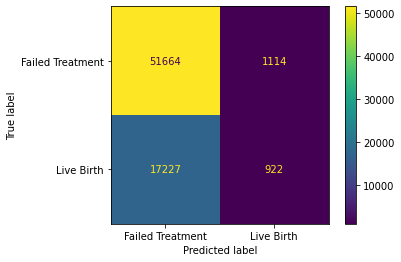

In [156]:
#Plot the Confusion Matrix for the second model
plot_confusion_matrix(second_model,
                      X_val, # <-- use validation data
                      y_val,
                      values_format='.0f',
                      display_labels=['Failed Treatment','Live Birth']);

In [157]:
TruePositive2 = 922 #Predicted live birth, actual live birth
TrueNegative2 = 51664 #Predicted failed treatment, actual failed treatment
FalsePositive2 = 1114 #Predicted live birth, but was a failed treatment
FalseNegative2 = 17227  #Predicted failed treatment, but resulted in a live birth

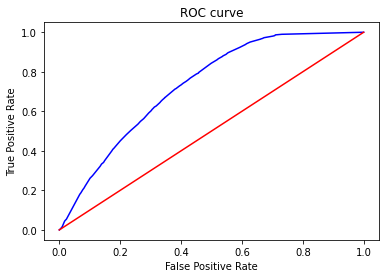

In [158]:
#Plot the ROC curve or Precision Recall Curve
y_pred_proba = second_model.predict_proba(X_val)[:,-1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

## Third Model

In [159]:
#Third Model
#Tree-Based Model (Random Forest)
model3_1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50,
                           n_jobs=-1,
                           random_state=42)
)

model3_1.fit(X_train, y_train);

In [160]:
#Evaluate the third model
third_model_train_score = model3_1.score(X_train, y_train)
third_model_baseline_training_set = third_model_train_score - baseline
print('Training Accuracy:',third_model_train_score)
print('Did the third model do better than the baseline on the training dataset?')
if (third_model_baseline_training_set)>0:
  print('Yes it did, by',third_model_baseline_training_set)
else:
  print('No it did worse by',third_model_baseline_training_set)

print(" ")
third_model_val_score = model3_1.score(X_val, y_val)
third_model_baseline_validation_set = third_model_val_score - baseline
print('Validation Accuracy:',third_model_val_score)
print('Did the third model do better than the baseline on the validation dataset?')
if (third_model_baseline_validation_set)>0:
  print('Yes it did, by',third_model_baseline_validation_set)
else:
  print('No it did worse by',third_model_baseline_validation_set)

Training Accuracy: 0.9189073551630543
Did the third model do better than the baseline on the training dataset?
Yes it did, by 0.16717252075784517
 
Validation Accuracy: 0.71666643168328
Did the third model do better than the baseline on the validation dataset?
No it did worse by -0.035068402721929126


In [161]:
#Tune the third model
model3_2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,
                           random_state=42)
)

model3_2.fit(X_train, y_train);

In [162]:
#Evaluate the tuned third model
third_model_tuned_train_score = model3_2.score(X_train, y_train)
print('Training Accuracy:',third_model_tuned_train_score)
print('Did the model improve on the Training Accuracy?')
if (third_model_tuned_train_score - third_model_train_score)>0: 
  print('Yes it did, by', third_model_tuned_train_score - third_model_train_score) 
else: print('No it did worse by', third_model_tuned_train_score - third_model_train_score)

print(" ")
third_tuned_model_baseline_training_set = third_model_tuned_train_score - baseline
print('Did the tuned third model do better than the baseline on the training dataset?')
if (third_tuned_model_baseline_training_set)>0:
  print('Yes it did, by',third_tuned_model_baseline_training_set)
else:
  print('No it did worse by',third_tuned_model_baseline_training_set)

print(" ")
third_model_tuned_val_score = model3_2.score(X_val, y_val)
print('Validation Accuracy:',third_model_tuned_val_score)
print('Did the model improve on the Validation Accuracy?')
if (third_model_tuned_val_score - third_model_val_score)>0: 
  print('Yes it did, by', third_model_tuned_val_score - third_model_val_score) 
else: print('No it did worse by', third_model_tuned_val_score - third_model_val_score)

print(" ")
third_tuned_model_baseline_validation_set = third_model_tuned_val_score - baseline
print('Did the tuned third model do better than the baseline on the validation dataset?')
if (third_tuned_model_baseline_validation_set)>0:
  print('Yes it did, by',third_tuned_model_baseline_validation_set)
else:
  print('No it did worse by',third_tuned_model_baseline_validation_set)

Training Accuracy: 0.9191212846465484
Did the model improve on the Training Accuracy?
Yes it did, by 0.0002139294834940797
 
Did the tuned third model do better than the baseline on the training dataset?
Yes it did, by 0.16738645024133925
 
Validation Accuracy: 0.7180622330001268
Did the model improve on the Validation Accuracy?
Yes it did, by 0.0013958013168468009
 
Did the tuned third model do better than the baseline on the validation dataset?
No it did worse by -0.033672601405082325


In [163]:
#Evaluate the model to see if the first iteration was better than the second or vise-versa
evaluate3 = {
    'Model Name': ['Model 3'],
    'Train 1': [third_model_train_score],
    'Train 2': [third_model_tuned_train_score],
    'Val 1': [third_model_val_score],
    'Val 2': [third_model_tuned_val_score]
}

evaluate3 = pd.DataFrame.from_dict(evaluate3)

evaluate3['Train Score'] = evaluate3['Train 2'] - evaluate3['Train 1']
evaluate3['Val Score'] = evaluate3['Val 2'] - evaluate3['Val 1']

print('Of the third model and the third tuned model, which improved the most on the baseline?')
if ((evaluate3['Train Score']>0).any() | (evaluate3['Val Score']>0).any()):
  evaluate3['Best Model'] = 'model3_2'
  print('The third model is better AFTER being tuned')
  third_model = model3_2
#elif ((evaluate3['Val Score']>0).any() | (evaluate3['Train Score']<0).any()):
#  evaluate3['Best Model'] = 'model3_2'
#  print('The third model is better AFTER being tuned')
#  third_model = model3_2
else: 
  evaluate3['Best Model'] = 'model3_1'
  third_model = model3_1
  print('The third model is better BEFORE being tuned')

evaluate3.head()

Of the third model and the third tuned model, which improved the most on the baseline?
The third model is better AFTER being tuned


,Model Name,Train 1,Train 2,Val 1,Val 2,Train Score,Val Score,Best Model
0,Model 3,0.918907,0.919121,0.716666,0.718062,0.000214,0.001396,model3_2


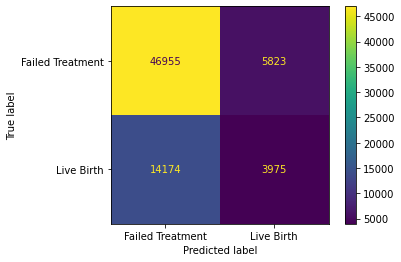

In [164]:
#Plot the Confusion Matrix for the third model
plot_confusion_matrix(third_model,
                      X_val, # <-- use validation data
                      y_val,
                      values_format='.0f',
                      display_labels=['Failed Treatment','Live Birth']);

In [165]:
TruePositive3 = 3975 #Predicted live birth, actual live birth
TrueNegative3 = 46955 #Predicted failed treatment, actual failed treatment
FalsePositive3 = 5823 #Predicted live birth, but was a failed treatment
FalseNegative3 = 14174 #Predicted failed treatment, but resulted in a live birth

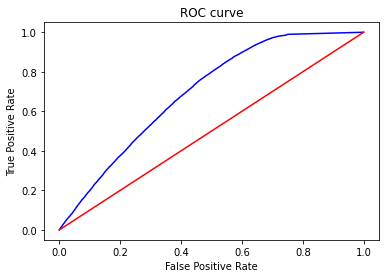

In [166]:
#Plot the ROC curve or Precision Recall Curve for the third model
y_pred_proba = third_model.predict_proba(X_val)[:,-1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

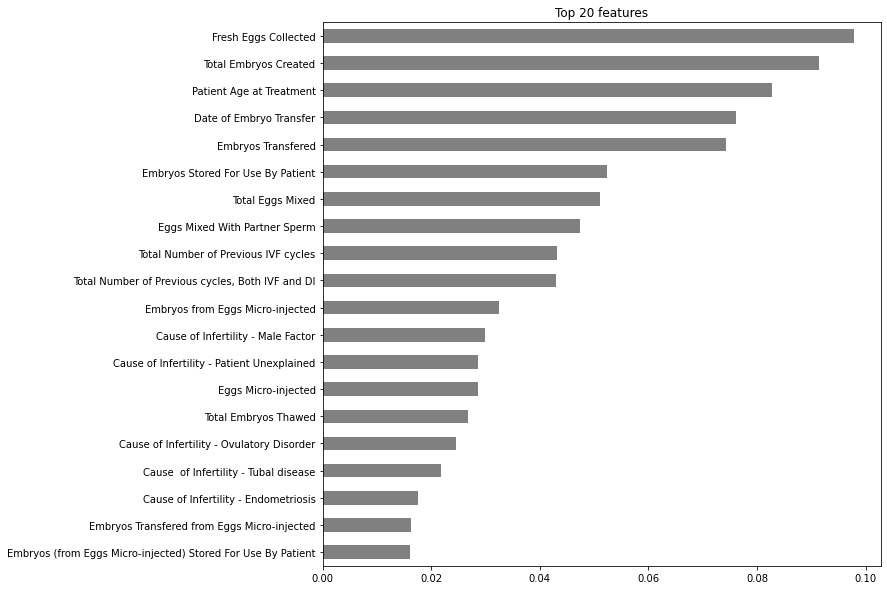

In [167]:
#Find important features 
# Get feature importances
rf = third_model.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Fourth Model

In [ ]:
#Fourth Model
#Build model using Permutation Importance
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

In [169]:
model4_1 = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

model4_1.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [170]:
#Evaluate the fourth model
fourth_model_train_score = model4_1.score(X_train, y_train)
fourth_model_baseline_training_set = fourth_model_train_score - baseline
print('Training Accuracy:',fourth_model_train_score)
print('Did the fourth model do better than the baseline on the training dataset?')
if (fourth_model_baseline_training_set)>0:
  print('Yes it did, by',fourth_model_baseline_training_set)
else:
  print('No it did worse by',fourth_model_baseline_training_set)

print(" ")
fourth_model_val_score = model4_1.score(X_val, y_val)
fourth_model_baseline_validation_set = fourth_model_val_score - baseline
print('Validation Accuracy:',fourth_model_val_score)
print('Did the fourth model do better than the baseline on the validation dataset?')
if (fourth_model_baseline_validation_set)>0:
  print('Yes it did, by',fourth_model_baseline_validation_set)
else:
  print('No it did worse by',fourth_model_baseline_validation_set)

Training Accuracy: 0.9191212846465484
Did the fourth model do better than the baseline on the training dataset?
Yes it did, by 0.16738645024133925
 
Validation Accuracy: 0.7180622330001268
Did the fourth model do better than the baseline on the validation dataset?
No it did worse by -0.033672601405082325


In [ ]:
#Tune the fourth model
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=200, random_state=55, n_jobs=-1)
model.fit(X_train_transformed, y_train)

In [172]:
model4_2 = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=3, 
    random_state=55
)

model4_2.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [173]:
#Evaluate the tuned fourth model
fourth_model_tuned_train_score = model4_2.score(X_train, y_train)
print('Training Accuracy:',fourth_model_tuned_train_score)
print('Did the model improve on the Training Accuracy?')
if (fourth_model_tuned_train_score - fourth_model_train_score)>0: 
  print('Yes it did, by', fourth_model_tuned_train_score - fourth_model_train_score) 
else: print('No it did worse by', fourth_model_tuned_train_score - fourth_model_train_score)

print(" ")
fourth_tuned_model_baseline_training_set = fourth_model_tuned_train_score - baseline
print('Did the tuned fourth model do better than the baseline on the training dataset?')
if (fourth_tuned_model_baseline_training_set)>0:
  print('Yes it did, by',fourth_tuned_model_baseline_training_set)
else:
  print('No it did worse by',fourth_tuned_model_baseline_training_set)

print(" ")
fourth_model_tuned_val_score = model4_2.score(X_val, y_val)
print('Validation Accuracy:',fourth_model_tuned_val_score)
print('Did the model improve on the Validation Accuracy?')
if (fourth_model_tuned_val_score - fourth_model_val_score)>0: 
  print('Yes it did, by', fourth_model_tuned_val_score - fourth_model_val_score) 
else: print('No it did worse by', fourth_model_tuned_val_score - fourth_model_val_score)

print(" ")
fourth_tuned_model_baseline_validation_set = fourth_model_tuned_val_score - baseline
print('Did the tuned fourth model do better than the baseline on the validation dataset?')
if (fourth_tuned_model_baseline_validation_set)>0:
  print('Yes it did, by',fourth_tuned_model_baseline_validation_set)
else:
  print('No it did worse by',fourth_tuned_model_baseline_validation_set)

Training Accuracy: 0.9191346552392667
Did the model improve on the Training Accuracy?
Yes it did, by 1.3370592718331409e-05
 
Did the tuned fourth model do better than the baseline on the training dataset?
Yes it did, by 0.16739982083405758
 
Validation Accuracy: 0.7198528064065871
Did the model improve on the Validation Accuracy?
Yes it did, by 0.0017905734064602719
 
Did the tuned fourth model do better than the baseline on the validation dataset?
No it did worse by -0.03188202799862205


In [174]:
#Evaluate the model to see if the first iteration was better than the second or vise-versa
evaluate4 = {
    'Model Name': ['Model 4'],
    'Train 1': [fourth_model_train_score],
    'Train 2': [fourth_model_tuned_train_score],
    'Val 1': [fourth_model_val_score],
    'Val 2': [fourth_model_tuned_val_score]
}

evaluate4 = pd.DataFrame.from_dict(evaluate4)

evaluate4['Train Score'] = evaluate4['Train 2'] - evaluate4['Train 1']
evaluate4['Val Score'] = evaluate4['Val 2'] - evaluate4['Val 1']

print('Of the fourth model and the fourth tuned model, which improved the most on the baseline?')
if ((evaluate4['Train Score']>0).any() | (evaluate4['Val Score']>0).any()):
  evaluate4['Best Model'] = 'model4_2'
  print('The fourth model is better AFTER being tuned')
  fourth_model = model4_2
#elif ((evaluate4['Val Score']>0).any() | (evaluate5['Train Score']<0).any()):
#  evaluate4['Best Model'] = 'model4_2'
#  print('The fourth model is better AFTER being tuned')
#  fourth_model = model4_2
else: 
  evaluate4['Best Model'] = 'model4_1'
  fourth_model = model4_1
  print('The fourth model is better BEFORE being tuned')

evaluate4.head()

Of the fourth model and the fourth tuned model, which improved the most on the baseline?
The fourth model is better AFTER being tuned


,Model Name,Train 1,Train 2,Val 1,Val 2,Train Score,Val Score,Best Model
0,Model 4,0.919121,0.919135,0.718062,0.719853,0.000013,0.001791,model4_2


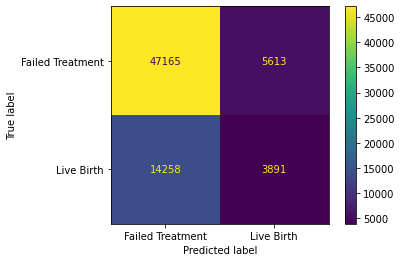

In [175]:
#Plot the Confusion Matrix for the fourth model
plot_confusion_matrix(fourth_model,
                      X_val, # <-- use validation data
                      y_val,
                      values_format='.0f',
                      display_labels=['Failed Treatment','Live Birth']);

In [176]:
TruePositive4 = 3891 #Predicted live birth, actual live birth
TrueNegative4 = 47165 #Predicted failed treatment, actual failed treatment
FalsePositive4 = 5613 #Predicted live birth, but was a failed treatment
FalseNegative4 = 14258 #Predicted failed treatment, but resulted in a live birth

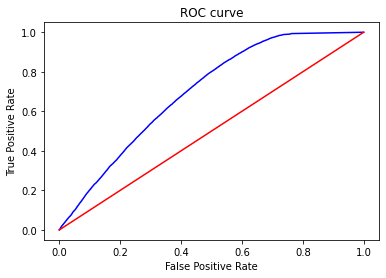

In [177]:
#Plot the ROC curve or Precision Recall Curve for the fourth model
y_pred_proba = fourth_model.predict_proba(X_val)[:,-1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

## Fifth Model

In [178]:
#Fifth Model
#Build model using XGB
model5_1 = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

)

model5_1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
      

In [179]:
#Evaluate the fifth model
fifth_model_train_score = model5_1.score(X_train, y_train)
fifth_model_baseline_training_set = fifth_model_train_score - baseline
print('Training Accuracy:',fifth_model_train_score)
print('Did the fifth model do better than the baseline on the training dataset?')
if (fifth_model_baseline_training_set)>0:
  print('Yes it did, by',fifth_model_baseline_training_set)
else:
  print('No it did worse by',fifth_model_baseline_training_set)

print(" ")
fifth_model_val_score = model5_1.score(X_val, y_val)
fifth_model_baseline_validation_set = fifth_model_val_score - baseline
print('Validation Accuracy:',fifth_model_val_score)
print('Did the fifth model do better than the baseline on the validation dataset?')
if (fifth_model_baseline_validation_set)>0:
  print('Yes it did, by',fifth_model_baseline_validation_set)
else:
  print('No it did worse by',fifth_model_baseline_validation_set)

Training Accuracy: 0.7557994945915952
Did the fifth model do better than the baseline on the training dataset?
Yes it did, by 0.004064660186386071
 
Validation Accuracy: 0.7459077643210625
Did the fifth model do better than the baseline on the validation dataset?
No it did worse by -0.005827070084146624


In [180]:
#Tune the fifth model
model5_2 = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=22, random_state=42, n_jobs=-1) 

)

model5_2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=22, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
       

In [181]:
#Evaluate the tuned fifth model
fifth_model_tuned_train_score = model5_2.score(X_train, y_train)
print('Training Accuracy:',fifth_model_tuned_train_score)
print('Did the model improve on the Training Accuracy?')
if (fifth_model_tuned_train_score - fifth_model_train_score)>0: 
  print('Yes it did, by', fifth_model_tuned_train_score - fifth_model_train_score) 
else: print('No it did worse by', fifth_model_tuned_train_score - fifth_model_train_score)

print(" ")
fifth_tuned_model_baseline_training_set = fifth_model_tuned_train_score - baseline
print('Did the tuned fifth model do better than the baseline on the training dataset?')
if (fifth_tuned_model_baseline_training_set)>0:
  print('Yes it did, by',fifth_tuned_model_baseline_training_set)
else:
  print('No it did worse by',fifth_tuned_model_baseline_training_set)

print(" ")
fifth_model_tuned_val_score = model5_2.score(X_val, y_val)
print('Validation Accuracy:',fifth_model_tuned_val_score)
print('Did the model improve on the Validation Accuracy?')
if (fifth_model_tuned_val_score - fifth_model_val_score)>0: 
  print('Yes it did, by', fifth_model_tuned_val_score - fifth_model_val_score) 
else: print('No it did worse by', fifth_model_tuned_val_score - fifth_model_val_score)

print(" ")
fifth_tuned_model_baseline_validation_set = fifth_model_tuned_val_score - baseline
print('Did the tuned fifth model do better than the baseline on the validation dataset?')
if (fifth_tuned_model_baseline_validation_set)>0:
  print('Yes it did, by',fifth_tuned_model_baseline_validation_set)
else:
  print('No it did worse by',fifth_tuned_model_baseline_validation_set)

Training Accuracy: 0.7517348344052092
Did the model improve on the Training Accuracy?
No it did worse by -0.004064660186386071
 
Did the tuned fifth model do better than the baseline on the training dataset?
No it did worse by 0.0
 
Validation Accuracy: 0.7441171909146024
Did the model improve on the Validation Accuracy?
No it did worse by -0.0017905734064601608
 
Did the tuned fifth model do better than the baseline on the validation dataset?
No it did worse by -0.007617643490606785


In [182]:
#Evaluate the model to see if the first iteration was better than the second or vise-versa
evaluate5 = {
    'Model Name': ['Model 5'],
    'Train 1': [fifth_model_train_score],
    'Train 2': [fifth_model_tuned_train_score],
    'Val 1': [fifth_model_val_score],
    'Val 2': [fifth_model_tuned_val_score]
}

evaluate5 = pd.DataFrame.from_dict(evaluate5)

evaluate5['Train Score'] = evaluate5['Train 2'] - evaluate5['Train 1']
evaluate5['Val Score'] = evaluate5['Val 2'] - evaluate5['Val 1']

print('Of the fifth model and the fifth tuned model, which improved the most on the baseline?')
if ((evaluate5['Train Score']>0).any() | (evaluate5['Val Score']>0).any()):
  evaluate5['Best Model'] = 'model5_2'
  print('The fifth model is better AFTER being tuned')
  fifth_model = model5_2
#elif ((evaluate5['Val Score']>0).any() | (evaluate5['Train Score']<0).any()):
#  evaluate5['Best Model'] = 'model5_2'
#  print('The fifth model is better AFTER being tuned')
#  fifth_model = model5_2
else: 
  evaluate5['Best Model'] = 'model5_1'
  fifth_model = model5_1
  print('The fifth model is better BEFORE being tuned')

evaluate5.head()

Of the fifth model and the fifth tuned model, which improved the most on the baseline?
The fifth model is better BEFORE being tuned


,Model Name,Train 1,Train 2,Val 1,Val 2,Train Score,Val Score,Best Model
0,Model 5,0.755799,0.751735,0.745908,0.744117,-0.004065,-0.001791,model5_1


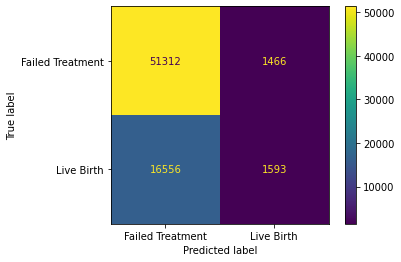

In [183]:
#Plot the Confusion Matrix for the fifth model
plot_confusion_matrix(fifth_model,
                      X_val, # <-- use validation data
                      y_val,
                      values_format='.0f',
                      display_labels=['Failed Treatment','Live Birth']);

In [184]:
#The fifth model did not predict any live births. 
TruePositive5 = 0 #Predicted live birth, actual live birth
TrueNegative5 = 52778 #Predicted failed treatment, actual failed treatment
FalsePositive5 = 0 #Predicted live birth, but was a failed treatment
FalseNegative5 = 18149 #Predicted failed treatment, but resulted in a live birth

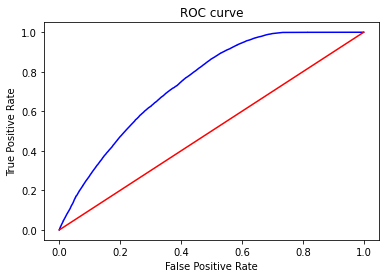

In [185]:
#Plot the ROC curve or Precision Recall Curve for the fifth model
y_pred_proba = fifth_model.predict_proba(X_val)[:,-1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

# Best model

In [196]:
accuracy = {
    'Model Name': ['Model 1','Model 2','Model 3','Model 4','Model 5'],
    'True Positive': [TruePositive1,TruePositive2,TruePositive3,TruePositive4,TruePositive5],
    'True Negative': [TrueNegative1,TrueNegative2,TrueNegative3,TrueNegative4,TrueNegative5],
    'False Positive': [FalsePositive1,FalsePositive2,FalsePositive3,FalsePositive4,FalsePositive5],
    'False Negative': [FalseNegative1,FalseNegative2,FalseNegative3,FalseNegative4,FalseNegative5]
}
accuracy = pd.DataFrame.from_dict(accuracy)

In [197]:
accuracy.head()

,Model Name,True Positive,True Negative,False Positive,False Negative
0,Model 1,639,51888,890,17510
1,Model 2,922,51664,1114,17227
2,Model 3,3975,46955,5823,14174
3,Model 4,3891,47165,5613,14258
4,Model 5,0,52778,0,18149


In [199]:
final_evaluation = pd.concat([evaluate1,evaluate2,evaluate3,evaluate4,evaluate5], ignore_index=True)
for i in final_evaluation['Best Model']:
  if i.endswith('_1'):
    final_evaluation['Best Model Score'] = final_evaluation['Train 1'] + final_evaluation['Val 1']
  elif i.endswith('_2'):
    final_evaluation['Best Model Score'] = final_evaluation['Train 2'] + final_evaluation['Val 2']
final_evaluation = pd.merge(final_evaluation,accuracy)
final_evaluation['Correct'] = final_evaluation['True Positive'] + final_evaluation['True Negative']
final_evaluation['Incorrect'] = final_evaluation['False Positive'] + final_evaluation['False Negative']
final_evaluation['Accuracy'] = final_evaluation['Correct'] - final_evaluation['Incorrect']
final_evaluation.head()

,Model Name,Train 1,Train 2,Val 1,Val 2,Train Score,Val Score,Best Model,Best Model Score,True Positive,True Negative,False Positive,False Negative,Correct,Incorrect,Accuracy
0,Model 1,0.747897,0.748379,0.739140,0.740480,0.000481,0.001339,model1_2,1.487038,639,51888,890,17510,52527,18400,34127
1,Model 2,0.919135,0.760854,0.688060,0.741410,-0.158281,0.053351,model2_2,1.607194,922,51664,1114,17227,52586,18341,34245
2,Model 3,0.918907,0.919121,0.716666,0.718062,0.000214,0.001396,model3_2,1.635574,3975,46955,5823,14174,50930,19997,30933
3,Model 4,0.919121,0.919135,0.718062,0.719853,0.000013,0.001791,model4_2,1.637184,3891,47165,5613,14258,51056,19871,31185
4,Model 5,0.755799,0.751735,0.745908,0.744117,-0.004065,-0.001791,model5_1,1.501707,0,52778,0,18149,52778,18149,34629


In [200]:
first_model_accuracy = first_model.score(X_train, y_train) + first_model.score(X_val, y_val)

second_model_accuracy = second_model.score(X_train, y_train) + second_model.score(X_val, y_val) 

third_model_accuracy = third_model.score(X_train, y_train) + third_model.score(X_val, y_val) 

fourth_model_accuracy = fourth_model.score(X_train, y_train) + fourth_model.score(X_val, y_val) 

fifth_model_accuracy = fifth_model.score(X_train, y_train) + fifth_model.score(X_val, y_val)

all_accuracy = [first_model_accuracy,second_model_accuracy,third_model_accuracy,fourth_model_accuracy,fifth_model_accuracy]

In [201]:
if first_model_accuracy == max(all_accuracy):
  print('The first model is the best model')
  final_model = first_model
elif second_model_accuracy == max(all_accuracy):
  print('The second model is the best model')
  final_model = second_model
elif third_model_accuracy == max(all_accuracy):
  print('The third model is the best model')
  final_model = third_model
elif fourth_model_accuracy == max(all_accuracy):
  print('The fourth model is the best model')
  final_model = fourth_model
elif fifth_model_accuracy == max(all_accuracy):
  print('The fifth model is the best model')
  final_model = fifth_model

The fourth model is the best model


In [202]:
#Evaluate the model against the test set 
print('Baseline',baseline)

final_training_accuracy = final_model.score(X_train, y_train) 
print('Training Accuracy:',final_training_accuracy)

final_validation_accuracy = final_model.score(X_val, y_val) 
print('Validation Accuracy:',final_validation_accuracy)

#I am only using the testing dataset once. 
testing_accuracy = final_model.score(X_test, y_test)
print('Testing Accuracy:',testing_accuracy)

Baseline 0.7517348344052092
Training Accuracy: 0.9191346552392667
Validation Accuracy: 0.7198387074033866
Testing Accuracy: 0.7140241614767014


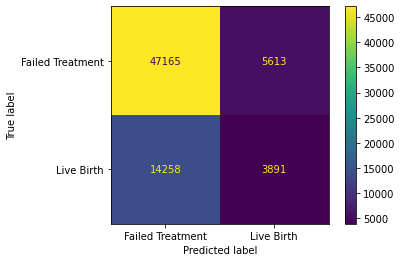

In [203]:
#Plot the Confusion Matrix for the fifth model
plot_confusion_matrix(final_model,
                      X_val, # <-- use validation data
                      y_val,
                      values_format='.0f',
                      display_labels=['Failed Treatment','Live Birth']);

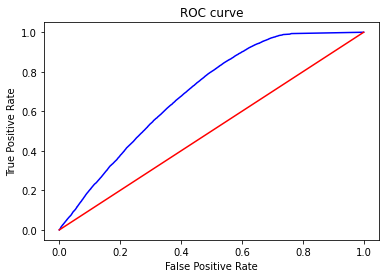

In [204]:
#Plot the ROC curve or Precision Recall Curve for the fifth model
y_pred_proba = final_model.predict_proba(X_val)[:,-1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

# Conclusions
Is this model helpful in predicting the target?

No.

Why not? 

It did not do better than the baseline on the test set and underestimated greatly the number of live births and predicted positive outcomes for patients when over 50% of those predictions were wrong. While this lines up with the basic psychology of going through fertility treatment. Most patients are hopeful even when the odds are against success I do not believe that this model meets my goal of determining whether going through IVF is worth it.

With the cost of going through IVF being so high, I wanted a more accurate model.